In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torchvision.utils as utils
from torch import nn
from tqdm import tqdm
from timeit import default_timer as timer
import albumentations as A
from albumentations import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
class DRIVE_dataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [img for img in os.listdir(img_dir) if img.endswith('.tif')]
        self.valid_pairs = []
        for img in self.images:
            if 'training' in img or 'test' in img:
                base_name = img.split('_')[0]
                mask_name = f"{base_name}_manual1.gif"
                mask_path = os.path.join(self.mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.valid_pairs.append((img, mask_name))
        if not self.valid_pairs:
            raise ValueError("No valid image-mask pairs")
        print(f"Found {len(self.valid_pairs)} valid pairs in {img_dir}")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, index):
        image_name, mask_name = self.valid_pairs[index]
        image_path = os.path.join(self.img_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # Binarize mask: make sure it's 0 and 1
        mask = (mask > 0).astype(np.uint8)

        # If needed, expand mask dims to HWC
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            mask = mask.float()
            mask = mask.permute(2,0,1)

        return image, mask

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(Unet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottle_neck = DoubleConv(512, 1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        x = self.bottle_neck(self.pool(x4))
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec4(x)
        return self.out_conv(x)

In [7]:
def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    if union == 0:
        return 0.0
    return (intersection + smooth) / (union + smooth)

def dice_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()
    pred_sum = pred.sum().item()
    target_sum = target.sum().item()
    #print(f"Pred sum: {pred_sum}, Target sum: {target_sum}")
    intersection = (pred * target).sum()
    denominator = pred.sum() + target.sum() + smooth
    if denominator == smooth:
        return 0.0
    return (2. * intersection + smooth) / denominator

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    denominator = pred.sum() + target.sum() + smooth
    if denominator == smooth:
        return 1.0
    return 1 - ((2. * intersection + smooth) / denominator)

def combined_loss(y_pred, y_true):
    bce = nn.BCEWithLogitsLoss()(y_pred, y_true)
    dice = dice_loss(y_pred, y_true)
    return 0.4 * bce + 0.6 * dice

In [8]:

def train_step(model, dataloader, criterion, optimizer):
    model.train()
    train_loss, train_dice,train_iou = 0, 0,0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_dice += dice_score(y_pred, y)
        train_iou += iou_score(y_pred,y)
    train_loss /= len(dataloader)
    train_dice /= len(dataloader)
    train_iou /= len(dataloader)
    return train_loss, train_dice,train_iou

In [9]:

def test_step(model, dataloader, criterion, epoch):
    model.eval()
    test_loss, test_dice,test_iou = 0, 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            test_dice += dice_score(y_pred, y)
            test_iou += iou_score(y_pred,y)
            #if batch == 8 :
                #utils.save_image(pred, f"pred_epoch_{epoch+1}.png")
                #utils.save_image(y, f"target_epoch_{epoch+1}.png")
            if batch == 0:
                pred = torch.sigmoid(y_pred)
                pred = (pred > 0.5).float()

    test_loss /= len(dataloader)
    test_dice /= len(dataloader)
    test_iou /= len(dataloader)
    return test_loss, test_dice,test_iou


In [10]:
def train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=100):

    results = {"train_loss": [], "train_dice": [],"train_iou": [], "test_loss": [], "test_dice": [],"test_iou":[]}
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    for epoch in tqdm(range(epochs)):
        train_loss, train_dice, train_iou = train_step(model, train_dataloader, criterion, optimizer)
        test_loss, test_dice,test_iou = test_step(model, test_dataloader, criterion, epoch)
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_dice: {train_dice:.4f} | train_iou : {train_iou:.4f} |"
              f"test_loss: {test_loss:.4f} | test_dice: {test_dice:.4f} | test_iou : {test_iou:.4f}")
        #scheduler.step(test_loss)
        results["train_loss"].append(train_loss)
        results["train_dice"].append(train_dice)
        results["train_iou"].append(train_iou)
        results["test_loss"].append(test_loss)
        results["test_dice"].append(test_dice)
        results["test_iou"].append(test_iou)
    return results


In [11]:
if __name__ == "__main__":
    transform = A.Compose([
    A.Resize(512, 512),
    #A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.3),
    #A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
    ToTensorV2(),
    ])
    image_transform = T.Compose([
        transform,
        #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    train_data = DRIVE_dataset(
        img_dir="/content/drive/MyDrive/retina-vessel-segmentation/data/DRIVE/training/images",
        mask_dir="/content/drive/MyDrive/retina-vessel-segmentation/data/DRIVE/training/1st_manual",
        transform=transform
    )
    test_data = DRIVE_dataset(
        img_dir="/content/drive/MyDrive/retina-vessel-segmentation/data/DRIVE/test/images",
        mask_dir="/content/drive/MyDrive/retina-vessel-segmentation/data/DRIVE/test/1st_manual",
        transform=transform
    )
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_data, batch_size=2, shuffle=False, num_workers=0)
    model = Unet(in_channels=3, out_channels=1).to(device)
    criterion = combined_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Found 20 valid pairs in /content/drive/MyDrive/retina-vessel-segmentation/data/DRIVE/training/images
Found 20 valid pairs in /content/drive/MyDrive/retina-vessel-segmentation/data/DRIVE/test/images


In [12]:
start_time = timer()
results = train(model, train_dataloader, test_dataloader, optimizer, criterion, epochs=50)
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  2%|▏         | 1/50 [01:21<1:06:47, 81.80s/it]

Epoch: 1 | train_loss: 0.6027 | train_dice: 0.3410 | train_iou : 0.2083 |test_loss: 0.8466 | test_dice: 0.0000 | test_iou : 0.0000


  4%|▍         | 2/50 [01:28<30:11, 37.73s/it]  

Epoch: 2 | train_loss: 0.4479 | train_dice: 0.5434 | train_iou : 0.3768 |test_loss: 0.8155 | test_dice: 0.0000 | test_iou : 0.0000


  6%|▌         | 3/50 [01:35<18:36, 23.76s/it]

Epoch: 3 | train_loss: 0.3844 | train_dice: 0.6142 | train_iou : 0.4464 |test_loss: 0.7667 | test_dice: 0.0016 | test_iou : 0.0008


  8%|▊         | 4/50 [01:42<13:07, 17.13s/it]

Epoch: 4 | train_loss: 0.3413 | train_dice: 0.6644 | train_iou : 0.4978 |test_loss: 0.6268 | test_dice: 0.1984 | test_iou : 0.1121


 10%|█         | 5/50 [01:49<10:08, 13.53s/it]

Epoch: 5 | train_loss: 0.3351 | train_dice: 0.6644 | train_iou : 0.4986 |test_loss: 0.4603 | test_dice: 0.4567 | test_iou : 0.3026


 12%|█▏        | 6/50 [01:57<08:19, 11.34s/it]

Epoch: 6 | train_loss: 0.3299 | train_dice: 0.6653 | train_iou : 0.4993 |test_loss: 0.3575 | test_dice: 0.6130 | test_iou : 0.4457


 14%|█▍        | 7/50 [02:04<07:10, 10.00s/it]

Epoch: 7 | train_loss: 0.3067 | train_dice: 0.6956 | train_iou : 0.5341 |test_loss: 0.3433 | test_dice: 0.6438 | test_iou : 0.4771


 16%|█▌        | 8/50 [02:11<06:21,  9.09s/it]

Epoch: 8 | train_loss: 0.3034 | train_dice: 0.6968 | train_iou : 0.5353 |test_loss: 0.3127 | test_dice: 0.6773 | test_iou : 0.5140


 18%|█▊        | 9/50 [02:18<05:50,  8.55s/it]

Epoch: 9 | train_loss: 0.2940 | train_dice: 0.7069 | train_iou : 0.5472 |test_loss: 0.3031 | test_dice: 0.6909 | test_iou : 0.5296


 20%|██        | 10/50 [02:26<05:26,  8.17s/it]

Epoch: 10 | train_loss: 0.2938 | train_dice: 0.7041 | train_iou : 0.5438 |test_loss: 0.2966 | test_dice: 0.6979 | test_iou : 0.5379


 22%|██▏       | 11/50 [02:33<05:10,  7.95s/it]

Epoch: 11 | train_loss: 0.2880 | train_dice: 0.7106 | train_iou : 0.5518 |test_loss: 0.2997 | test_dice: 0.6921 | test_iou : 0.5312


 24%|██▍       | 12/50 [02:41<04:57,  7.84s/it]

Epoch: 12 | train_loss: 0.2829 | train_dice: 0.7150 | train_iou : 0.5571 |test_loss: 0.2971 | test_dice: 0.6964 | test_iou : 0.5360


 26%|██▌       | 13/50 [02:48<04:45,  7.72s/it]

Epoch: 13 | train_loss: 0.2744 | train_dice: 0.7245 | train_iou : 0.5684 |test_loss: 0.2908 | test_dice: 0.7009 | test_iou : 0.5411


 28%|██▊       | 14/50 [02:56<04:37,  7.70s/it]

Epoch: 14 | train_loss: 0.2725 | train_dice: 0.7253 | train_iou : 0.5695 |test_loss: 0.2793 | test_dice: 0.7124 | test_iou : 0.5549


 30%|███       | 15/50 [03:03<04:27,  7.66s/it]

Epoch: 15 | train_loss: 0.2677 | train_dice: 0.7296 | train_iou : 0.5757 |test_loss: 0.2807 | test_dice: 0.7076 | test_iou : 0.5497


 32%|███▏      | 16/50 [03:11<04:21,  7.69s/it]

Epoch: 16 | train_loss: 0.2687 | train_dice: 0.7256 | train_iou : 0.5700 |test_loss: 0.2674 | test_dice: 0.7233 | test_iou : 0.5680


 34%|███▍      | 17/50 [03:19<04:14,  7.71s/it]

Epoch: 17 | train_loss: 0.2586 | train_dice: 0.7384 | train_iou : 0.5860 |test_loss: 0.2857 | test_dice: 0.7024 | test_iou : 0.5423


 36%|███▌      | 18/50 [03:27<04:08,  7.76s/it]

Epoch: 18 | train_loss: 0.2591 | train_dice: 0.7360 | train_iou : 0.5833 |test_loss: 0.2691 | test_dice: 0.7209 | test_iou : 0.5653


 38%|███▊      | 19/50 [03:35<04:03,  7.85s/it]

Epoch: 19 | train_loss: 0.2537 | train_dice: 0.7411 | train_iou : 0.5893 |test_loss: 0.2647 | test_dice: 0.7256 | test_iou : 0.5705


 40%|████      | 20/50 [03:43<03:54,  7.83s/it]

Epoch: 20 | train_loss: 0.2485 | train_dice: 0.7470 | train_iou : 0.5968 |test_loss: 0.2587 | test_dice: 0.7297 | test_iou : 0.5757


 42%|████▏     | 21/50 [03:50<03:47,  7.83s/it]

Epoch: 21 | train_loss: 0.2504 | train_dice: 0.7423 | train_iou : 0.5906 |test_loss: 0.2599 | test_dice: 0.7309 | test_iou : 0.5768


 44%|████▍     | 22/50 [03:58<03:38,  7.79s/it]

Epoch: 22 | train_loss: 0.2477 | train_dice: 0.7444 | train_iou : 0.5934 |test_loss: 0.2562 | test_dice: 0.7331 | test_iou : 0.5795


 46%|████▌     | 23/50 [04:06<03:30,  7.78s/it]

Epoch: 23 | train_loss: 0.2424 | train_dice: 0.7505 | train_iou : 0.6011 |test_loss: 0.2585 | test_dice: 0.7244 | test_iou : 0.5699


 48%|████▊     | 24/50 [04:14<03:22,  7.80s/it]

Epoch: 24 | train_loss: 0.2419 | train_dice: 0.7494 | train_iou : 0.5998 |test_loss: 0.2501 | test_dice: 0.7379 | test_iou : 0.5855


 50%|█████     | 25/50 [04:21<03:14,  7.77s/it]

Epoch: 25 | train_loss: 0.2385 | train_dice: 0.7526 | train_iou : 0.6038 |test_loss: 0.2475 | test_dice: 0.7409 | test_iou : 0.5892


 52%|█████▏    | 26/50 [04:29<03:06,  7.77s/it]

Epoch: 26 | train_loss: 0.2358 | train_dice: 0.7547 | train_iou : 0.6063 |test_loss: 0.2504 | test_dice: 0.7333 | test_iou : 0.5800


 54%|█████▍    | 27/50 [04:37<02:58,  7.75s/it]

Epoch: 27 | train_loss: 0.2358 | train_dice: 0.7530 | train_iou : 0.6046 |test_loss: 0.2410 | test_dice: 0.7429 | test_iou : 0.5915


 56%|█████▌    | 28/50 [04:45<02:50,  7.76s/it]

Epoch: 28 | train_loss: 0.2353 | train_dice: 0.7521 | train_iou : 0.6035 |test_loss: 0.2405 | test_dice: 0.7437 | test_iou : 0.5926


 58%|█████▊    | 29/50 [04:52<02:43,  7.76s/it]

Epoch: 29 | train_loss: 0.2328 | train_dice: 0.7542 | train_iou : 0.6059 |test_loss: 0.2402 | test_dice: 0.7431 | test_iou : 0.5919


 60%|██████    | 30/50 [05:00<02:35,  7.76s/it]

Epoch: 30 | train_loss: 0.2269 | train_dice: 0.7613 | train_iou : 0.6148 |test_loss: 0.2332 | test_dice: 0.7512 | test_iou : 0.6021


 62%|██████▏   | 31/50 [05:08<02:27,  7.78s/it]

Epoch: 31 | train_loss: 0.2240 | train_dice: 0.7639 | train_iou : 0.6183 |test_loss: 0.2352 | test_dice: 0.7480 | test_iou : 0.5979


 64%|██████▍   | 32/50 [05:16<02:19,  7.75s/it]

Epoch: 32 | train_loss: 0.2269 | train_dice: 0.7582 | train_iou : 0.6109 |test_loss: 0.2379 | test_dice: 0.7407 | test_iou : 0.5891


 66%|██████▌   | 33/50 [05:23<02:11,  7.74s/it]

Epoch: 33 | train_loss: 0.2209 | train_dice: 0.7653 | train_iou : 0.6202 |test_loss: 0.2327 | test_dice: 0.7479 | test_iou : 0.5980


 68%|██████▊   | 34/50 [05:31<02:03,  7.72s/it]

Epoch: 34 | train_loss: 0.2209 | train_dice: 0.7640 | train_iou : 0.6186 |test_loss: 0.2298 | test_dice: 0.7517 | test_iou : 0.6026


 70%|███████   | 35/50 [05:39<01:55,  7.72s/it]

Epoch: 35 | train_loss: 0.2189 | train_dice: 0.7655 | train_iou : 0.6207 |test_loss: 0.2276 | test_dice: 0.7543 | test_iou : 0.6060


 72%|███████▏  | 36/50 [05:47<01:48,  7.75s/it]

Epoch: 36 | train_loss: 0.2168 | train_dice: 0.7672 | train_iou : 0.6229 |test_loss: 0.2366 | test_dice: 0.7374 | test_iou : 0.5850


 74%|███████▍  | 37/50 [05:54<01:40,  7.73s/it]

Epoch: 37 | train_loss: 0.2206 | train_dice: 0.7610 | train_iou : 0.6146 |test_loss: 0.2352 | test_dice: 0.7411 | test_iou : 0.5893


 76%|███████▌  | 38/50 [06:02<01:32,  7.73s/it]

Epoch: 38 | train_loss: 0.2144 | train_dice: 0.7685 | train_iou : 0.6243 |test_loss: 0.2237 | test_dice: 0.7562 | test_iou : 0.6084


 78%|███████▊  | 39/50 [06:10<01:24,  7.70s/it]

Epoch: 39 | train_loss: 0.2120 | train_dice: 0.7706 | train_iou : 0.6272 |test_loss: 0.2219 | test_dice: 0.7572 | test_iou : 0.6097


 80%|████████  | 40/50 [06:17<01:17,  7.71s/it]

Epoch: 40 | train_loss: 0.2128 | train_dice: 0.7682 | train_iou : 0.6242 |test_loss: 0.2285 | test_dice: 0.7490 | test_iou : 0.5994


 82%|████████▏ | 41/50 [06:25<01:09,  7.74s/it]

Epoch: 41 | train_loss: 0.2109 | train_dice: 0.7696 | train_iou : 0.6259 |test_loss: 0.2234 | test_dice: 0.7508 | test_iou : 0.6018


 84%|████████▍ | 42/50 [06:33<01:01,  7.73s/it]

Epoch: 42 | train_loss: 0.2080 | train_dice: 0.7731 | train_iou : 0.6304 |test_loss: 0.2245 | test_dice: 0.7492 | test_iou : 0.5996


 86%|████████▌ | 43/50 [06:41<00:54,  7.75s/it]

Epoch: 43 | train_loss: 0.2072 | train_dice: 0.7727 | train_iou : 0.6299 |test_loss: 0.2199 | test_dice: 0.7542 | test_iou : 0.6058


 88%|████████▊ | 44/50 [06:48<00:46,  7.74s/it]

Epoch: 44 | train_loss: 0.2029 | train_dice: 0.7779 | train_iou : 0.6369 |test_loss: 0.2176 | test_dice: 0.7579 | test_iou : 0.6106


 90%|█████████ | 45/50 [06:56<00:38,  7.76s/it]

Epoch: 45 | train_loss: 0.2035 | train_dice: 0.7760 | train_iou : 0.6344 |test_loss: 0.2123 | test_dice: 0.7641 | test_iou : 0.6185


 92%|█████████▏| 46/50 [07:04<00:31,  7.79s/it]

Epoch: 46 | train_loss: 0.2023 | train_dice: 0.7764 | train_iou : 0.6348 |test_loss: 0.2161 | test_dice: 0.7587 | test_iou : 0.6115


 94%|█████████▍| 47/50 [07:12<00:23,  7.79s/it]

Epoch: 47 | train_loss: 0.2020 | train_dice: 0.7763 | train_iou : 0.6347 |test_loss: 0.2123 | test_dice: 0.7625 | test_iou : 0.6164


 96%|█████████▌| 48/50 [07:20<00:15,  7.80s/it]

Epoch: 48 | train_loss: 0.1999 | train_dice: 0.7786 | train_iou : 0.6377 |test_loss: 0.2299 | test_dice: 0.7326 | test_iou : 0.5790


 98%|█████████▊| 49/50 [07:27<00:07,  7.76s/it]

Epoch: 49 | train_loss: 0.2033 | train_dice: 0.7726 | train_iou : 0.6298 |test_loss: 0.2143 | test_dice: 0.7555 | test_iou : 0.6076


100%|██████████| 50/50 [07:35<00:00,  9.11s/it]

Epoch: 50 | train_loss: 0.1985 | train_dice: 0.7786 | train_iou : 0.6379 |test_loss: 0.2106 | test_dice: 0.7613 | test_iou : 0.6152
Total training time: 455.565 seconds


In [13]:
torch.save(model.state_dict(), 'unet_weights.pth')


In [14]:
saved_model = Unet(in_channels=3, out_channels=1).to(device)
saved_model.load_state_dict(torch.load("/content/unet_weights.pth", weights_only=True))



<All keys matched successfully>

In [15]:
import torch
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation (must match training)
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
    ToTensorV2(),
])


In [16]:

saved_model = Unet(in_channels=3, out_channels=1).to(device)
saved_model.load_state_dict(torch.load("/content/unet_weights.pth", weights_only=True))
saved_model.eval()

Unet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1

In [20]:




# Load image (example .tif image path)
img_path = "/content/drive/MyDrive/retina-vessel-segmentation/data/DRIVE/test/images/09_test.tif"
image = Image.open(img_path).convert("RGB")
image_np = np.array(image) # needed for albumentations

# Apply transform
transformed = transform(image=image_np)
input_tensor = transformed["image"].unsqueeze(dim = 0).to(device)
input_tensor.shape


torch.Size([1, 3, 512, 512])

In [21]:
# Inference
with torch.no_grad():
    pred = torch.sigmoid(saved_model(input_tensor))
    pred_mask = (pred > 0.5).float().squeeze().cpu().numpy()

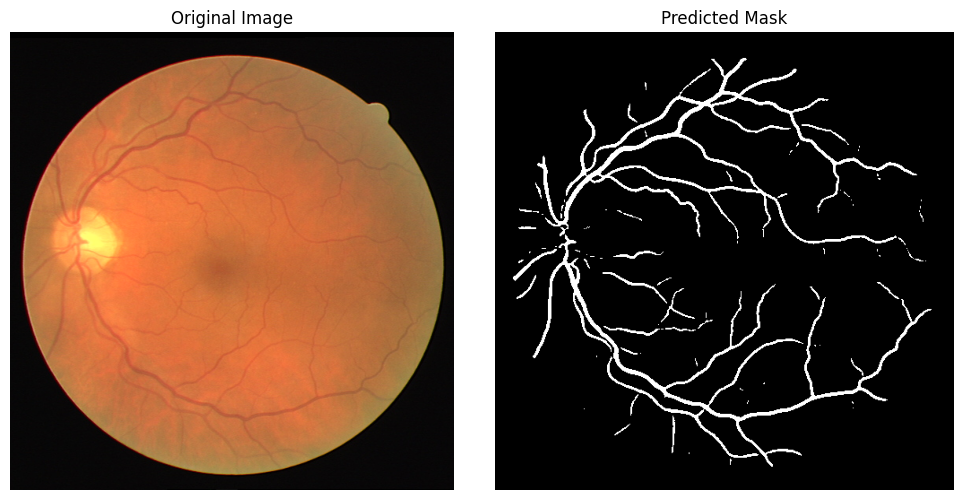

In [22]:
# Plot original and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()